In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

24264


# Basic processing for Hi-C raw data

In [15]:
hic_raw_folder = r'\\10.245.74.212\Chromatin_NAS_3\HiC_cortex'
hic_raw_fl = os.path.join(hic_raw_folder, 'hic_raw_map.npy')

# 1.1 load HiC raw

In [23]:
%%time
# If load hic raw map (# n-by-3 array as bin-i; bin-j; contact count)
hic_raw_contacts = np.load(hic_raw_fl) # array as bin-i; bin-j; contact count

# If load hic region annotation (# n-by-4 array as chr;start;end;bin-name)
hic_reg_savename = os.path.join(hic_raw_folder, "hic_reg_annotation.npy")
hic_raw_regs = np.load(hic_reg_savename)

print(hic_raw_regs.shape)  # array as chr;start;end;bin-name

(250885, 4)
Wall time: 3.24 s


In [548]:
raw_df = pd.DataFrame(hic_raw_regs.astype(np.int32),columns=['chr','start','end','name'])

In [550]:
raw_df[raw_df['chr']==20]['name']

1              1
3              2
5              3
7              4
9              5
           ...  
250880    136285
250881    136286
250882    136287
250883    136288
250884    136289
Name: name, Length: 127737, dtype: int32

In [547]:
np.unique(hic_raw_regs[:,0])

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

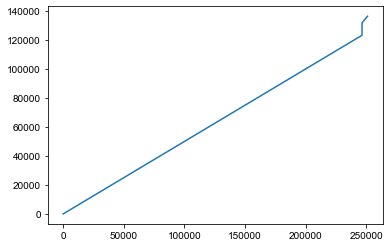

In [552]:
plt.figure()
plt.plot(raw_df[raw_df['chr']==20]['name'])

In [499]:
hic_sel_regs = []
curr_reg = 0
curr_start = -1
for _reg_info in hic_raw_regs:
    #print(_reg_info[-1], curr_reg)
    if _reg_info[-1] != curr_reg and _reg_info[1] > curr_start:
        hic_sel_regs.append(_reg_info)
        curr_reg = _reg_info[-1]
        curr_start = _reg_info[1]
    elif _reg_info[-1] != curr_reg and hic_sel_regs[-1][0] != _reg_info[0]:
        hic_sel_regs.append(_reg_info)
        curr_reg = _reg_info[-1]
        curr_start = _reg_info[1]
    else:
        continue
hic_sel_regs = np.array(hic_sel_regs)

In [563]:
hic_save_folder = r'W:\HiC_cortex\hic_map_cortex_20kb'

In [564]:
hic_reg_df.to_csv(os.path.join(hic_save_folder, 'filtered_regions.csv'), 
                  index=False)

In [540]:
hic_reg_df[hic_reg_df['chr']==20]

,chr,start,end,name
123148,20,0,20000,131701
123149,20,20000,40000,131702
123150,20,40000,60000,131703
123151,20,60000,80000,131704
123152,20,80000,100000,131705
...,...,...,...,...
127731,20,91660000,91680000,136284
127732,20,91680000,91700000,136285
127733,20,91700000,91720000,136286
127734,20,91720000,91740000,136287


In [506]:
import pandas as pd
hic_reg_df = pd.DataFrame(hic_sel_regs.astype(np.int32),columns=['chr','start','end','name'])

In [524]:
chr_2_contact = {}
chr_2_regDf = {}
#for _chr in np.unique(hic_reg_df['chr']):
# select specific chr
_chr = 19
print(_chr)
_chr_reg_df = hic_reg_df.loc[hic_reg_df['chr']==_chr].sort_values('start')
_chr_contacts = np.zeros([len(_chr_reg_df),len(_chr_reg_df)], dtype=np.int32)
print(_chr_contacts.shape)
_chr_reg_lst = list(_chr_reg_df['name'].values)
_chr_reg_min, _chr_reg_max = np.min(_chr_reg_lst), np.max(_chr_reg_lst)
# loop through contacts
for _bi, _bj, _ct in tqdm(hic_raw_contacts):
    if _bi >= _chr_reg_min and _bi <= _chr_reg_max and _bj >= _chr_reg_min and _bj <= _chr_reg_max:
        _bi, _bj = int(_bi),int(_bj)
        if _bi in _chr_reg_lst and _bj in _chr_reg_lst:
            _chr_contacts[_chr_reg_lst.index(_bi), _chr_reg_lst.index(_bj)] += _ct
chr_2_contact[_chr] = _chr_contacts
chr_2_regDf[_chr] = _chr_reg_df

19
(3072, 3072)


100%|███████████████████████████████████████████████████████████████████| 37155393/37155393 [06:52<00:00, 90149.25it/s]


C:\Users\puzheng\AppData\Local\Temp/ipykernel_18448/1845969662.py:2: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(_chr_contacts, vmin=1e-3, vmax=10, norm=LogNorm())


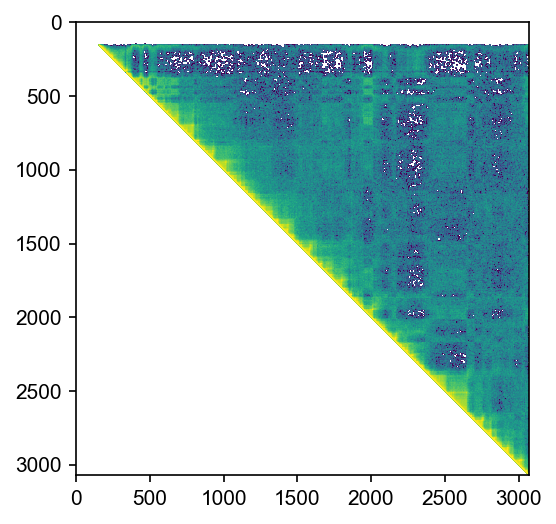

In [528]:
plt.figure(dpi=150)
plt.imshow(_chr_contacts, vmin=1e-3, vmax=10, norm=LogNorm())
plt.show()

In [531]:
raw_500_19 = np.load(os.path.join(r'W:\HiC_cortex\hic_map_cortex_20kb', 'HiC_20kb_chr_19.npy'))

In [537]:
np.unique(np.diag(raw_500_19-_chr_contacts,1))

array([0.])

<IPython.core.display.Javascript object>


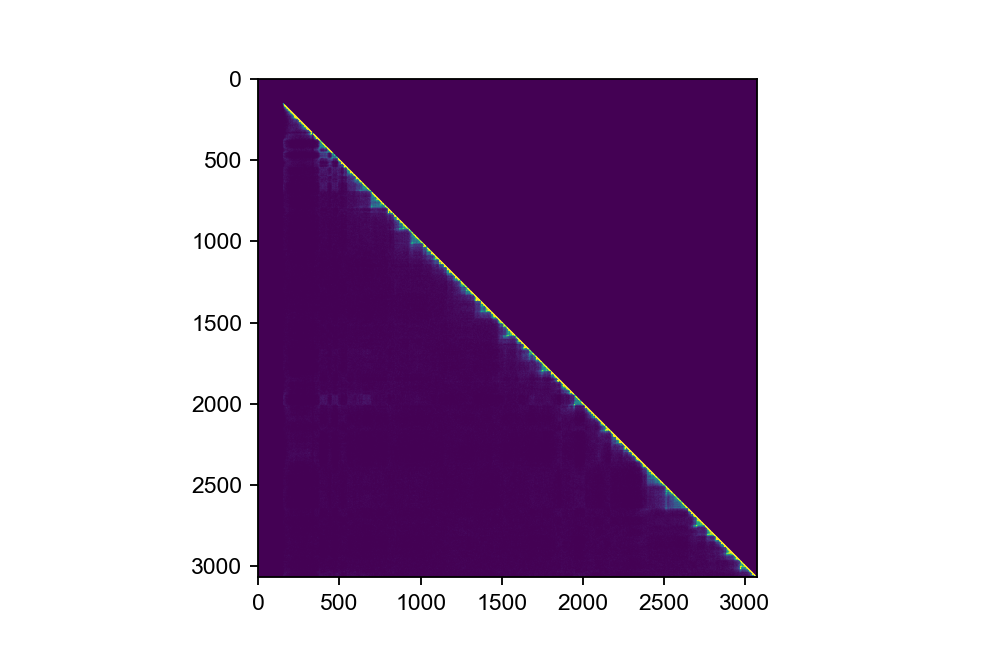

In [558]:
%matplotlib notebook
plt.figure(dpi=150)
plt.imshow(raw_500_19-_chr_contacts, vmin=1e-3, vmax=10, )#norm=LogNorm())
plt.show()

In [521]:
raw_500_x = np.load(os.path.join(r'W:\HiC_cortex\hic_map_cortex_original\hic_map_merged_ctp11-13_regions\500kb', 'hic_ctp11-13_raw_500kb_merged_for_chrX.npy'))

C:\Users\puzheng\AppData\Local\Temp/ipykernel_18448/3149974194.py:2: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(raw_500_x, vmin=1e-2, vmax=1, norm=LogNorm())


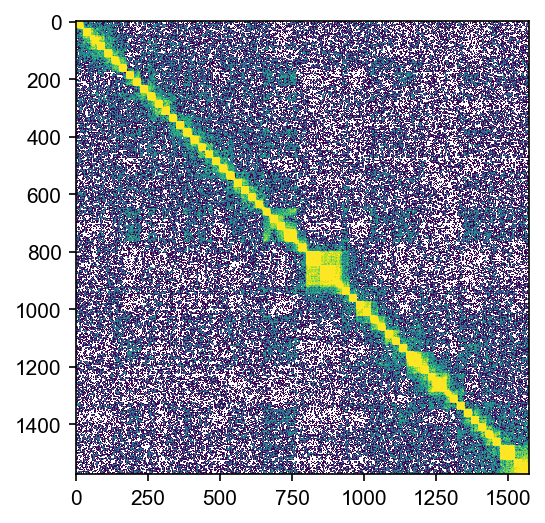

In [523]:
plt.figure(dpi=150)
plt.imshow(raw_500_x, vmin=1e-2, vmax=1, norm=LogNorm())
plt.show()

<IPython.core.display.Javascript object>


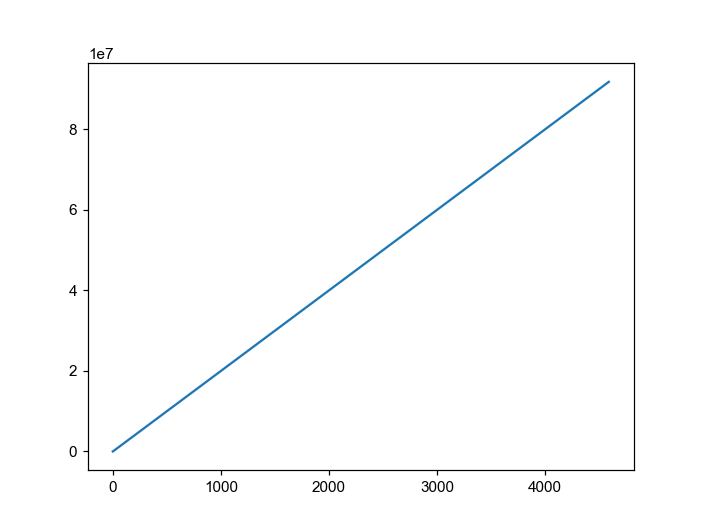

In [86]:
plt.plot(_chr_reg_df['start'].values)

In [66]:
_chr_reg_df

,chr,start,end,name
1,20,0,20000,1
3,20,20000,40000,2
5,20,40000,60000,3
7,20,60000,80000,4
9,20,80000,100000,5
...,...,...,...,...
250880,20,91680000,91700000,136285
250881,20,91700000,91720000,136286
250882,20,91720000,91740000,136287
250883,20,91740000,91744698,136288


In [ ]:
chr_2_reg_df = {}


In [ ]:
compute_hic_map_for_bin(hic_raw_contacts)

In [32]:
hic_raw_regs.shape

(250885, 4)

In [33]:
hic_raw_contacts[0]

array([151., 151., 128.])

In [35]:
# Convert hic_contacts+regions into matrix
from tqdm import tqdm
fill_symmetric = True

hic_matrix = np.zeros([hic_raw_regs.shape[0], hic_raw_regs.shape[0]],
                       dtype=np.int32)    
# loop
for _ri, _rj, _ct in tqdm(hic_raw_contacts):
    hic_matrix[int(_ri), int(_rj)] = _ct
    
    

MemoryError: Unable to allocate 234. GiB for an array with shape (250885, 250885) and data type int32

In [29]:
# function to compute the hi-c count map for given bin array using loop
from tqdm import tqdm

def compute_hic_map_for_bin (hic_raw_map,
                             bin_of_interest,
                             #compress_bin = 1,
                             duplicate_tri = True,
                            ):
    
    # initiate hic-count map
    _hic_count_map = np.zeros([len(bin_of_interest),len(bin_of_interest)])
    print(f'-- computing hi-c count map for {len(bin_of_interest)} loci/bins.')
    
    #ijs=[]
    #for i in range(len(bin_of_interest)):
        #for j in range(len(bin_of_interest)):
            #ijs.append((i,j))        
    #for i,j in tqdm.notebook.tqdm(ijs):
        
    # dual-loop to append count to the count map
    for _ind_i, _bin_i in enumerate(tqdm(bin_of_interest)):
        rows = hic_raw_map[hic_raw_map[:,0]==_bin_i]
        #print(f'-- process count map for the {_ind_i+1} locus/bin.')
        
        for _ind_j, _bin_j in enumerate(bin_of_interest):
            # only compute for the upper trianglular -- check the source hic_raw_map to see if count is reported as i vs j (i<j)
            if _bin_i <= _bin_j:
                col = rows[rows[:,1]==_bin_j]
                # if there is a single count value, add
                if len(col)==1:
                    _hic_count_map[_ind_i,_ind_j]=col[0,-1]           

    # duplicate the lower trianglular half hic
    if duplicate_tri:
        _hic_count_map = _hic_count_map + _hic_count_map.T - np.diag(np.diag(_hic_count_map))
        
    return _hic_count_map

In [24]:
hic_raw_regs (# n-by-4 array as chr;start;end;bin-name)

array([[1.0000000e+00, 0.0000000e+00, 2.0000000e+04, 1.0000000e+00],
       [2.0000000e+01, 0.0000000e+00, 2.0000000e+04, 1.0000000e+00],
       [1.0000000e+00, 2.0000000e+04, 4.0000000e+04, 2.0000000e+00],
       ...,
       [2.0000000e+01, 9.1720000e+07, 9.1740000e+07, 1.3628700e+05],
       [2.0000000e+01, 9.1740000e+07, 9.1744698e+07, 1.3628800e+05],
       [2.0000000e+01, 0.0000000e+00, 1.6299000e+04, 1.3628900e+05]])

In [182]:
# function to compress the hi-c count map by binning the previusoly merged bins
def compress_hic_map (hic_count_map, compress_size =1): 
    
    print(f'-- Input count map shape is {hic_count_map.shape}.')
    if len(hic_count_map.shape) !=2 or hic_count_map.shape[0]!=hic_count_map.shape[1]:
        print(f'-- Input count map is invalid.')
        return None
    
    # add empty pseduo bins if the last ctp loci does not have enough hic bins to merge
    if len(hic_count_map)%compress_size !=0:
        print(f'-- Add empty bins to the input map to enable the compression.')
        residual = len(hic_count_map)%compress_size
        add_num = compress_size - residual 
        new_dim = len(hic_count_map)+add_num
        new_hic_count_map = np.zeros([new_dim,new_dim])
        new_hic_count_map[:len(hic_count_map),:len(hic_count_map)]=hic_count_map
        hic_count_map =new_hic_count_map
        
    print(f'-- Summing the input count map over every {compress_size} loci')
    # reshape to split the rows into (splitted_rows, compress_size, cols ) and sum the splitted_row along the compression-axis
    new_row_num = int(hic_count_map.shape[-1]/compress_size)
    sum_count_row = hic_count_map.reshape(new_row_num,compress_size,hic_count_map.shape[-1]).sum(1) #sum along axis 1
    # reshape to split the col into (splitted_rows, compress_size, splitted_cols) and splitted_cols along the compression-axis
    new_col_num = new_row_num
    sum_count_row_col = sum_count_row.reshape(new_row_num,new_col_num,compress_size).sum(2) #sum along axis 2
    #print(sum_count_row_col.shape)
    
    return sum_count_row_col

-- Input count map shape is (9774, 9774).
-- Summing the input count map over every 3 loci


In [184]:
merged_hic_map.shape

(3258, 3258)

In [91]:
import numpy as np

In [92]:
chr_1_mat = np.load(r'W:\HiC_cortex\hic_map_cortex_20kb\HiC_20kb_chr_1.npy')

In [107]:
chr_1_reg_df = hic_reg_df.loc[hic_reg_df['chr']==1]
chr_1_reg_starts = chr_1_reg_df['start'].values

In [374]:
# merge resolution
merge_bins = 2
#merged_hic_map = chr_1_mat[0::2,0::2]+chr_1_mat[1::2,1::2]+chr_1_mat[1::2,0::2]+chr_1_mat[0::2,1::2]
merged_hic_map = compress_hic_map(chr_1_mat, merge_bins)
merged_gstarts = chr_1_reg_starts[::merge_bins]

from scipy.spatial.distance import pdist, squareform
_gdist_map = squareform(pdist(merged_gstarts[:,np.newaxis]))

-- Input count map shape is (9774, 9774).
-- Summing the input count map over every 2 loci


In [375]:
gdist_entries = _gdist_map[np.triu_indices(len(_gdist_map),1)]
hic_entries = merged_hic_map[np.triu_indices(len(merged_hic_map),1)]

kept_flags = (hic_entries > 0) * (gdist_entries > 0)

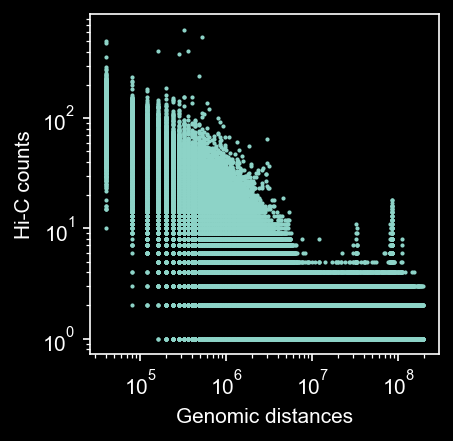

In [574]:
%matplotlib inline
plt.style.use('dark_background')
fig, ax = plt.subplots(dpi=150, figsize=(3,3))
ax.scatter(gdist_entries[kept_flags], hic_entries[kept_flags], s=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Genomic distances")
ax.set_ylabel("Hi-C counts")
plt.show()
#fig.show()

In [406]:
dists = np.unique(gdist_entries)

valid_dists = []
mean_counts = []
zero_fracs = []
for _d in dists:
    _cts = hic_entries[np.where(gdist_entries==_d)]
    _zero_fr = np.mean(_cts==0)
    if _zero_fr < 1:
        valid_dists.append(_d)
        mean_counts.append(np.mean(_cts))
        zero_fracs.append(_zero_fr)

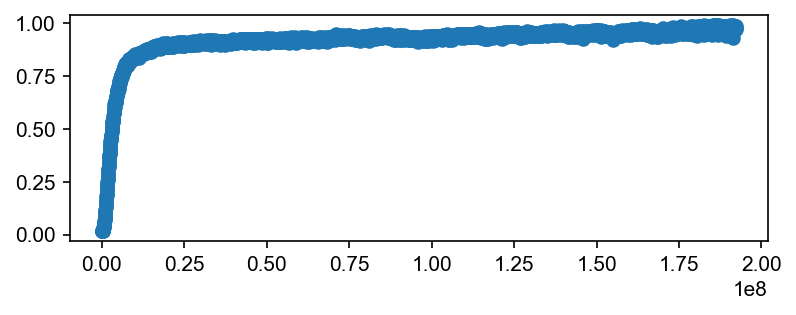

In [407]:
%matplotlib inline
plt.figure(figsize=(6,2), dpi=150)
plt.plot(valid_dists, zero_fracs, '-o')
plt.show()

In [409]:
hic_lr = scipy.stats.linregress(np.log(valid_dists), np.log(mean_counts))
print(hic_lr)

LinregressResult(slope=-0.6681541606966575, intercept=9.443799999741367, rvalue=-0.9143267231021309, pvalue=0.0, stderr=0.00427110385028194, intercept_stderr=0.07731594979593376)


In [474]:
hic_poly = np.polyfit(np.log(valid_dists), np.log(mean_counts) ,deg=5)

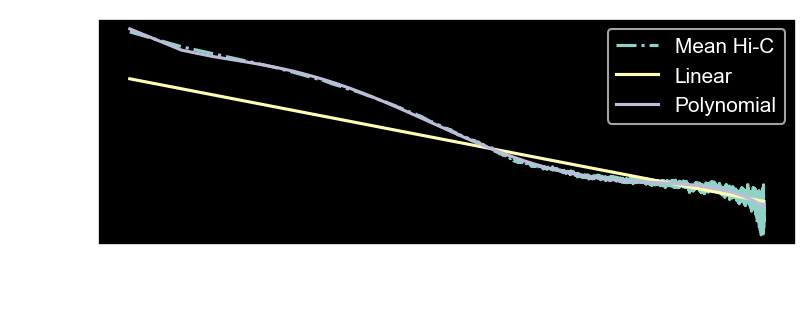

In [583]:
%matplotlib inline
plt.figure(figsize=(6,2), dpi=150)
plt.plot(np.log(valid_dists), np.log(mean_counts), '-.', label='Mean Hi-C')
plt.plot(np.log(valid_dists), (np.log(valid_dists) * hic_lr.slope + hic_lr.intercept), '-', label='Linear')
plt.plot(np.log(valid_dists), np.polyval(hic_poly, np.log(valid_dists)), label='Polynomial')
plt.xlabel("Log genomic distance")
plt.ylabel("Log Hi-C counts")
plt.legend()
plt.show()

In [476]:
hic_gdist_norm = np.exp(np.polyval(hic_poly, np.log(_gdist_map)))

C:\Users\puzheng\AppData\Local\Temp/ipykernel_18448/2724077451.py:1: RuntimeWarning: divide by zero encountered in log
  hic_gdist_norm = np.exp(np.polyval(hic_poly, np.log(_gdist_map)))
E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\numpy\lib\polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [478]:
hic_gdist_norm = np.exp(np.polyval(hic_poly, np.log(_gdist_map)))
hic_gdist_norm[np.arange(len(hic_gdist_norm)),np.arange(len(hic_gdist_norm))] = 1e10
hic_normed_map = merged_hic_map / hic_gdist_norm

from scipy.ndimage import gaussian_filter
from numpy import ma

gaussian_sigma = 1.5
valid_inds = np.where(hic_normed_map.sum(0) > 0)[0]

hic_corr_map = np.corrcoef(gaussian_filter(hic_normed_map[valid_inds, valid_inds[:,np.newaxis]], gaussian_sigma))
#hic_corr_map = ma.corrcoef(ma.masked_invalid(hic_normed_map))

C:\Users\puzheng\AppData\Local\Temp/ipykernel_18448/2191227804.py:2: RuntimeWarning: divide by zero encountered in log
  hic_gdist_norm = np.exp(np.polyval(hic_poly, np.log(_gdist_map)))


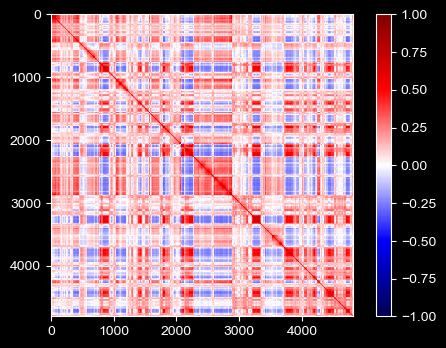

In [585]:
plt.style.use('dark_background')

plt.figure(dpi=100)
plt.imshow(hic_corr_map, vmin=-1, vmax=1, cmap='seismic')#norm=LogNorm(0.1,5))
plt.colorbar()
plt.show()

In [480]:
from sklearn.decomposition import PCA
hic_model = PCA(1)
hic_model.fit(hic_corr_map)
hic_pc1 = np.reshape(hic_model.fit_transform(hic_corr_map), -1)

In [481]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

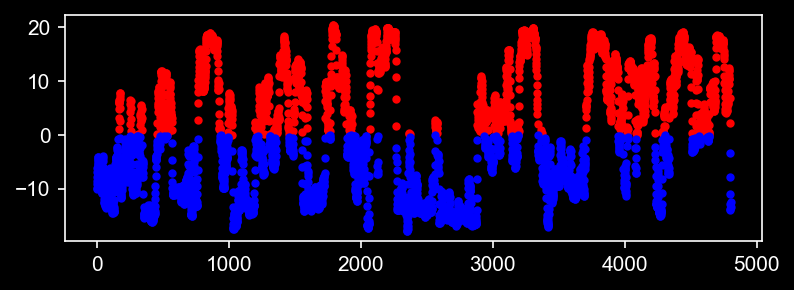

In [587]:
hic_fig, hic_ax = plt.subplots(figsize=(6,2),dpi=150)
hic_ax.plot(np.where(hic_pc1>=0)[0], hic_pc1[np.where(hic_pc1>=0)[0]], '.', linewidth=1, color='r', label='A')
hic_ax.plot(np.where(hic_pc1<0)[0], hic_pc1[np.where(hic_pc1<0)[0]], '.', linewidth=1, color='b', label='B')

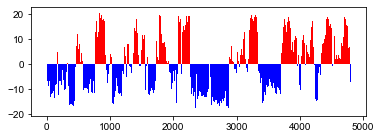

In [437]:
hic_fig, hic_ax = plt.subplots(figsize=(6,2))
hic_ax.bar(np.where(hic_pc1>=0)[0],
               hic_pc1[hic_pc1>=0],
               width=1, color='r', label='A')
hic_ax.bar(np.where(hic_pc1<0)[0],
               hic_pc1[hic_pc1<0],
               width=1, color='b', label='B')
plt.show()